In [ ]:
# 목표: 주가 데이터 -> 캔들차트 이미지 변환 -> CNN 학습!
# 참고: https://github.com/quant4junior/algoTrade/blob/master/ch08/8.1%20CNN%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%BA%94%EB%93%A4%EC%B0%A8%ED%8A%B8%20%EC%98%88%EC%B8%A1%EB%B6%84%EC%84%9D/run_all_process.ipynb

In [10]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [1]:
!apt-get install zip unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
# 압축풀기 : 한글깨짐 방지: -O cp949
!unzip -O cp949 /content/dataset.zip
!rm -rf /content/dataset.zip

In [64]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
from collections import defaultdict
import numpy as np
# import scipy.misc
from matplotlib.pyplot import imread

def dataset(base_dir, n):
    print("base_dir : {}, n : {}".format(base_dir, n))
    d = defaultdict(list)
    for root, subdirs, files in os.walk(base_dir):
        #print('root :', root)
        #print('subdirs :', subdirs)
        #print('files :',files)

        # for filename in subdirs:
        for filename in files:
            file_path = os.path.join(root, filename)
            #print(' ok :', file_path)

            assert file_path.startswith(base_dir)
            suffix = file_path[len(base_dir):]
            #print('suffix : ', suffix)
            # suffix = suffix.lstrip("\\")
            # label = suffix.split("\\")[0]
            suffix = suffix.lstrip("/")
            label = suffix.split("/")[0]
            d[label].append(file_path)

    tags = sorted(d.keys())
    print("classes : {}".format(tags))

    X = []
    y = []

    for class_index, class_name in enumerate(tags):
        filenames = d[class_name]
        for filename in filenames:
            suffix = filename[len(base_dir):]
            #print('suffix : ', suffix)
            #suffix = suffix.lstrip("\\")
            #label = suffix.split("\\")[0]
            #print('filename :: ', filename, ' ,suffix : ', suffix, ' ,label:', label)
#             img = scipy.misc.imread(filename) # 없어짐.
            img = imread(filename)
            height, width, chan = img.shape
            # assert chan == 4
            assert chan == 3

            X.append(img)
            y.append(class_index)

    X = np.array(X).astype(np.float32)
    y = np.array(y)
    print('X.shape: ', X.shape, ' ,y:', y.shape, ' ,tags:', len(tags))
    #print('end loading : ', base_dir)

    return X, y, tags

In [65]:
# 5.모델학습

# import tensorflow as tf
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

import math
import json
import sys

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
from keras.layers import Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import initializers
from keras.engine import Layer, InputSpec
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import *
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from utils.dataset import dataset
import argparse

import time
from datetime import timedelta

def build_dataset(data_directory, img_width):
    # X, y, tags = dataset.dataset(data_directory, int(img_width))
    X, y, tags = dataset(data_directory, int(img_width))
    #print(len(tags))
    nb_classes = len(tags)

    sample_count = len(y)
    train_size = sample_count
    print("train size : {}".format(train_size))
    feature = X
    label = np_utils.to_categorical(y, nb_classes)
    return feature, label, nb_classes

def build_model(SHAPE, nb_classes, bn_axis, seed=None):
    print("--build_model start--")
    if seed: np.random.seed(seed)

    input_layer = Input(shape=SHAPE)
    print('input_layer:', input_layer.shape)

    # (2021/03/10,juk) init -> kernel_initializer, border_mode -> padding

    # Step 1
    x = Conv2D(32, 3, 3, kernel_initializer ='glorot_uniform', padding='same', activation='relu')(input_layer)
    # Step 2 - Pooling
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) # (2021/03/10,juk) add padding='same'
    
    # Step 1
    x = Conv2D(48, 3, 3, kernel_initializer ='glorot_uniform', padding='same',activation='relu')(x)
    # Step 2 - Pooling
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    # Step 1
    x = Conv2D(64, 3, 3, kernel_initializer ='glorot_uniform', padding='same', activation='relu')(x)
    # Step 2 - Pooling
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Step 1
    x = Conv2D(96, 3, 3, kernel_initializer ='glorot_uniform', padding='same', activation='relu')(x)
    # Step 2 - Pooling
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    # Step 3 - Flattening
    x = Flatten()(x)
    
    # Step 4 - Full connection
    x = Dense(256, activation='relu')(x) # (2021/03/10,juk) output_dim=256 -> 256
    
    # Dropout
    #x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    
    model = Model(input_layer, x)
    model.summary()

    return model

In [92]:
def myDeepCNN_main(input, output, dimension=50, channel=3, epochs=50, batch_size=8):
    # parser = argparse.ArgumentParser(
    #     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # parser.add_argument('-i', '--input',
    #                     help='an input directory of dataset', required=True)
    # parser.add_argument('-d', '--dimension',
    #                     help='a image dimension', type=int, default=48)
    # parser.add_argument('-c', '--channel',
    #                     help='a image channel', type=int, default=3)
    # parser.add_argument('-e', '--epochs',
    #                     help='num of epochs', type=int, default=10)
    # parser.add_argument('-b', '--batch_size',
    #                     help='num of batch_size', type=int, default=64)
    # # parser.add_argument('-o', '--optimizer',
    # #                     help='choose the optimizer (rmsprop, adagrad, adadelta, adam, adamax, nadam)', default="adam")
    # parser.add_argument('-o', '--output',
    #                     help='a result file', type=str, default="hasilnya.txt")
    # args = parser.parse_args()

    # dimensions of our images.
    img_width, img_height = dimension, dimension
    channel = channel
    epochs = epochs
    batch_size = batch_size
    SHAPE = (img_width, img_height, channel)
    #bn_axis = 3 if K.image_dim_ordering() == 'tf' else 1
    bn_axis = 3 if K.image_data_format() == 'tf' else 1

    # channel = 4
    # bn_axis = 4 if K.image_dim_ordering() == 'tf' else 1

    data_directory = input

    print("loading train dataset")
    X_train, Y_train, nb_classes = build_dataset("{}/train".format(data_directory), dimension)
    print("number of train classes : {}".format(nb_classes))

    model = build_model(SHAPE, nb_classes, bn_axis)
    model.compile(optimizer=Adam(lr=1.0e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    print('X_train:', X_train.shape, ' ,Y_train:', Y_train.shape)
    # Fit the model
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

    # Save Model or creates a HDF5 file
    model.save('{}epochs_{}batch_cnn_model_{}.h5'.format(epochs, batch_size, data_directory.replace("/", "_")), overwrite=True)

    return model

In [93]:
# print(f'python myDeepCNN.py "-i" "dataset/dataset_BBNIJK_20_50" "-e" "50" "-d" "50" "-b" "8" "-o" "outputresult.txt"')
# subprocess.call(f'python myDeepCNN.py "-i" "dataset/dataset_BBNIJK_20_50" "-e" "50" "-d" "50" "-b" "8" "-o" "outputresult.txt"', shell=True)

#def myDeepCNN_main(input, output, dimension=50, channel=3, epochs=50, batch_size=8):
start_time = time.monotonic()
input_dir = "dataset/dataset_005930.KS20_50"
output_file = "outputresult.txt"
dimension = 50
epochs = 50
batch_size = 8

model = myDeepCNN_main(input_dir, output_file, dimension, 3, epochs, batch_size)

loading train dataset
base_dir : dataset/dataset_005930.KS20_50/train, n : 50
classes : ['0', '1']
X.shape:  (228, 50, 50, 3)  ,y: (228,)  ,tags: 2
train size : 228
number of train classes : 2
--build_model start--
input_layer: (None, 50, 50, 3)
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 17, 17, 32)        896       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 3, 3, 48)          13872     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 2, 2, 48)          0         
__________

In [101]:
print("loading test dataset")
X_test, Y_test, nb_classes = build_dataset("{}/test".format(input_dir), dimension)
print("number of test classes : {}".format(nb_classes))

loading test dataset
base_dir : dataset/dataset_005930.KS20_50/test, n : 50
classes : ['0', '1']
X.shape:  (22, 50, 50, 3)  ,y: (22,)  ,tags: 2
train size : 22
number of test classes : 2


In [102]:
def wirteResultToFile(cm, output):        
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]
    if tp == 0: tp = 1
    if tn == 0: tn = 1
    if fp == 0: fp = 1
    if fn == 0: fn = 1
    TPR = float(tp)/(float(tp)+float(fn))
    FPR = float(fp)/(float(fp)+float(tn))
    accuracy = round((float(tp) + float(tn))/(float(tp) + float(fp) + float(fn) + float(tn)), 3)
    specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
    sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
    mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
        (float(tp)+float(fp))
        * (float(tp)+float(fn))
        * (float(tn)+float(fp))
        * (float(tn)+float(fn))
    ), 3)

    f_output = open(output, 'a')
    f_output.write('=======\n')
    f_output.write('{}epochs_{}batch_cnn\n'.format(epochs, batch_size))
    f_output.write('TN: {}\n'.format(tn))
    f_output.write('FN: {}\n'.format(fn))
    f_output.write('TP: {}\n'.format(tp))
    f_output.write('FP: {}\n'.format(fp))
    f_output.write('TPR: {}\n'.format(TPR))
    f_output.write('FPR: {}\n'.format(FPR))
    f_output.write('accuracy: {}\n'.format(accuracy))
    f_output.write('specitivity: {}\n'.format(specitivity))
    f_output.write("sensitivity : {}\n".format(sensitivity))
    f_output.write("mcc : {}\n".format(mcc))
    f_output.write("{}".format(report))
    f_output.write('=======\n')
    f_output.close()    

#evaluate
loss_and_metrics = model.evaluate(X_test, Y_test)
print('loss_and_metrics : ' + str(loss_and_metrics))
print('')

#predict test set
predicted = model.predict(X_test)
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

wirteResultToFile(cm, output_file)
end_time = time.monotonic()
print("Duration : {}".format(timedelta(seconds=end_time - start_time)))


1/1 [==============================] - 0s 122ms/step - loss: 0.8053 - accuracy: 0.5455
loss_and_metrics : [0.8052783608436584, 0.5454545617103577]

Duration : 0:03:50.599150


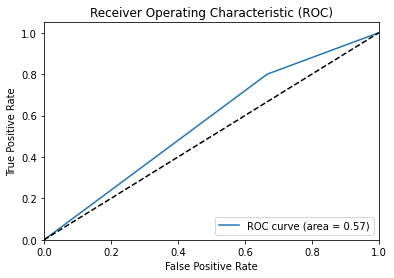

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred, y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('ROC AUC.png')
    plt.show()

plot_roc(y_pred, Y_test)